# Flows

Flows are used to evolve a curve over time. Specific flows are subclasses of the abstract superclass `curvey.flow.Flow`.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from curvey import Curve, Curves
from curvey.flow import CurveShorteningFlow, SingularityFreeMeanCurvatureFlow, WillmoreFlow
from curvey.shape_structure_dataset import ShapeStructureDataset

In [2]:
plt.rcParams["axes.titlesize"] = 10

## Curve shortening flow
The simplest form implemented in curvey is Curve Shortening Flow, which moves curve vertices in the direction of the vertex normal, scaled by the curvature at that vertex. For a cool interactive demonstration of CSF, see [https://a.carapetis.com/csf/]().

Flows are calculated with an auxillary `Solver` object constructed by the `Flow.solver` method:

In [3]:
dumbbell = Curve.dumbbell(n=100, rx=1.25).rotate(np.pi / 2)
csf = CurveShorteningFlow()
solver = csf.solver(
    initial=dumbbell,
    timestep=1e-3,
    max_step=300,
)
solver.run()  # returns the same solver object for convenience

Solver(flow=CurveShorteningFlow, current=Curve(n=36, time=0.3000000000000002, step=300, timestep=0.001))

By default, the solver stores the curve at each timestep during the run in its `history` property, a `curvey.Curves` object.

In [4]:
solver.history

Curves(n=301, data={idx, step, time, timestep})

 Under curve-shortening flow, the curve should smooth out and approach a circle, eventually collapsing into a round point. Plotted on the left below is the curve roundness $P^2/ {4 \pi A}$ for perimeter $P$ and area $A$, which should be 1.0 for a perfect circle and greater than 1 otherwise

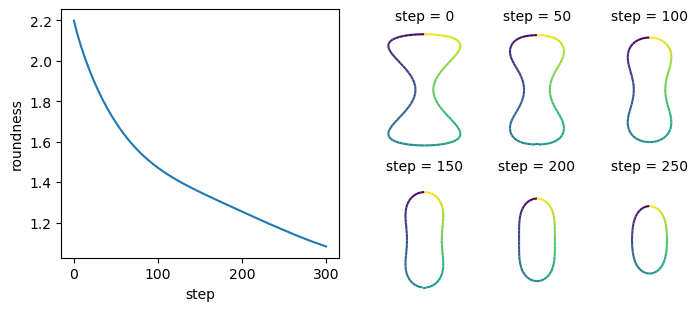

In [5]:
fig = plt.figure(layout="constrained", figsize=(7, 3))
subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1, 1])
ax0 = subfigs[0].subplots()
solver.history.plot(y='roundness', x='step', label_axes=True, ax=ax0)

axs1 = subfigs[1].subplots(2, 3, sharex=True, sharey=True)
solver.history.subplots(subtitle='step', axs=axs1);

A difficulty with CSF is that it can be numerically unstable; by default the curve is resampled each iteration to maintain a uniform distribution of vertices. With resampling off, we can see the flow break down:

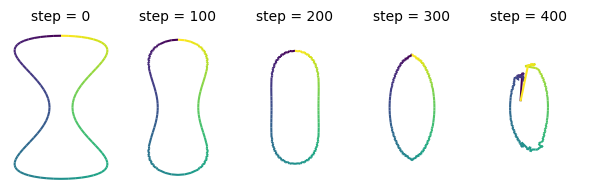

In [10]:
_ = CurveShorteningFlow(resample_mode=None).solver(
    initial=dumbbell,
    timestep=1e-3,
    max_step=500,
).run().history.subplots(1, 5, subtitle='step', figsize=(6, 3))

## Singularity-free mean curvature flow

An implementation of [*Can Mean-Curvature Flow Be Made Non-Singular?* Michael Kazhdan, Jake Solomon, and Mirela Ben-Chen.
2012.](https://arxiv.org/abs/1203.6819) It's much more stable and doesn't require reparametrization:

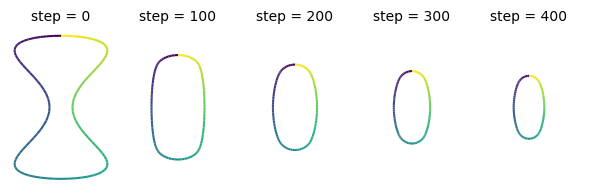

In [11]:
_ = SingularityFreeMeanCurvatureFlow().solver(
    initial=dumbbell,
    timestep=0.1,
    max_step=500,
).run().history.subplots(
    n_cols=5, subtitle='step', figsize=(6, 3),
)

## Willmore flow

An implementation of [*Robust Fairing via Conformal Curvature Flow.* Keenan Crane, Ulrich Pinkall, and Peter Schröder. 2014.](
https://www.cs.cmu.edu/~kmcrane/Projects/ConformalWillmoreFlow/paper.pdf) Willmore flow operates on vertex curvatures, rather than vertex coordinates, and is faster because it can take much larger timesteps. Because it operates isometrically, the curve doesn't shrink but instead maintains its total length. In this example, instead of specifying a `timestep` and `max_step`, we'll specify a `stop_tol` which allows 
the solver to automatically determine an adaptive step-size and stopping condition from the energy gradient.

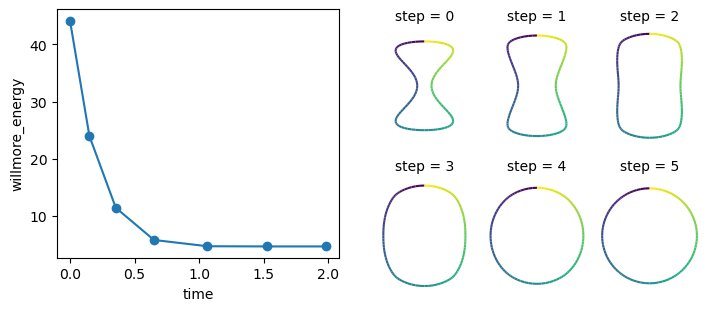

In [13]:
wf = WillmoreFlow()
circle_solver = wf.solver(initial=dumbbell, stop_tol=1e-3).run()

fig = plt.figure(layout="constrained", figsize=(7, 3))
subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1, 1])
ax0 = subfigs[0].subplots()
circle_solver.history.plot(
    y='willmore_energy', x='time', 
    label_axes=True, ax=ax0, marker='o')

axs1 = subfigs[1].subplots(2, 3, sharex=True, sharey=True)
circle_solver.history.subplots(subtitle='step', axs=axs1);

### Filtered Willmore flow
`WillmoreFlow` accepts two filter arguments `filter_width` and `filter_shape`. These are the $\sigma$ and $k$ parameters in the Crane et al. paper. (Section 4, see Figure 8.) They shape the flow by filtering out high or low frequency curvature changes, depending on the `filter_shape` parameter.

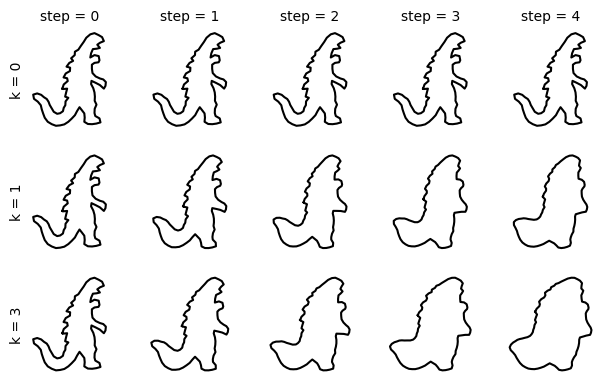

In [19]:
dataset = ShapeStructureDataset("~/Downloads/ShapesJSON.zip")
dino = dataset.load_curve('dino')

filter_shapes = (0, 1, 3)
n_shapes = len(filter_shapes)
n_steps = 5
sz = 1.5
fig, axs = plt.subplots(
    nrows=n_shapes, 
    ncols=n_steps, 
    figsize=(sz * n_steps, sz * n_shapes),
)

for i, filter_shape in enumerate(filter_shapes):
    wf = WillmoreFlow(
        filter_width=.1, filter_shape=filter_shape)
    solver = wf.solver(
        initial=dino, max_step=n_steps, timestep=0.075)
    solver.run()
    solver.history.subplots(
        axs=axs[[i], :], plot_fn=Curve.plot, show_axes=False) 

for i in range(n_steps):
    axs[0, i].set_title(f'step = {i}')

for i, k in enumerate(filter_shapes):
    axs[i, 0].set_ylabel(f'k = {k}')

### Targeted Willmore flow
Instead of flowing down the gradient of Wilmore energy $\kappa^2$, we can supply a target curvature and flow down the gradient 
$(\kappa - \kappa_{\text {target}})^2$

In [17]:
# Start from the circle we just flowed to in the last example
circle = circle_solver.current

# Resample to make sure we have uniform distribution of edge lengths
circle = circle.interpolate_n(n=circle.n)

# Construct a target with the same total length and number of vertices
star = (
    Curve.star(n=5, r0=0.75, r1=1.5)
    .interpolate_n(n=circle.n)
    .to_length(circle.length)
)

# Flow from the circle to the star
wf = WillmoreFlow(tgt_curvature=star.curvature)
tgt_solver = wf.solver(initial=circle, max_step=10).run()

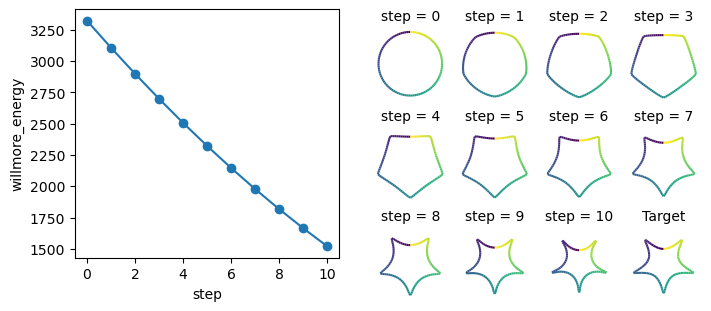

In [18]:
fig = plt.figure(layout="constrained", figsize=(7, 3))
subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1, 1])
ax0 = subfigs[0].subplots()
tgt_solver.history.plot(
    y='willmore_energy', 
    x='step', 
    label_axes=True, 
    ax=ax0, 
    marker='o',
)

axs1 = subfigs[1].subplots(3, 4, sharex=True, sharey=True)
tgt_solver.history.subplots(subtitle='step', axs=axs1);

# Plot the target in the last axes for comparison
# Account for rotation/translation
aligned = star.align_to(tgt_solver.history[-1])  
last_ax = axs1.flatten()[-1]
_ = aligned.plot_edges(directed=False, ax=last_ax)
_ = last_ax.set_title('Target')